# Benchmark to find threshold for filtering low-variance features

See https://git.bia-christian.de/bia/lab_book_VEO/wiki/feature-selection#remove-low-variance-features

In [43]:
#Turn off scientific notation
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})

#Activate print all activities
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import input

In [50]:
import pickle
import zstandard
import pandas as pd
import numpy as np
import datetime

print("Started script! Loading input file...", datetime.datetime.now())

#feature = 'kmer9Classification'
#feature = 'gene-familiesClassification'
feature = 'gene-familiesRegression'

abiotic_factor = 'salt'
#abiotic_factor = 'temperature'

#group = 'Salinity group'
group = 'Salt all mean'
#group = 'Temp group'

file1 = '/home/bia/Documents/bacterial_phenotypes/connecting_features_abFactors/df_' + abiotic_factor + '_' + feature + '_selected-filterNA.pickle.zst'  

with zstandard.open(file1, 'rb') as f:
	df = pickle.load(f)

print("Loaded input pickle zst file...", datetime.datetime.now())
df.head()
df.shape

Started script! Loading input file... 2024-07-10 14:26:07.970398
Loaded input pickle zst file... 2024-07-10 14:26:08.107000


,COG3696@2,COG0606@2,33SZW@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,2Z7XP@2,COG1086@2,...,arCOG06650@2157,"Viruses,4R0IQ@35237",arCOG09713@2157,arCOG07735@2157,arCOG07334@2157,arCOG04203@2157,arCOG01811@2157,arCOG00087@2157,arCOG07496@2157,Salt all mean
Best assembly,,,,,,,,,,,,,,,,,,,,,
1121349.4,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15.00
1121909.4,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,45.00
1123508.3,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5.00
1218801.3,1,1,0,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,27.50
1420583.3,1,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25.00


(3418, 20142)

# Create files for filtering low-variance features with different thresholds

In [27]:
#CLASSIFICATION #########################################
#STEP NECESSARY BEFORE CREATING FILES ###################

#Replace string to int for target variable
df[group] = df[group].replace(['low'], 0)
df[group] = df[group].replace(['medium'], 2)
df[group] = df[group].replace(['high'], 1)

#MAKE SURE THE NUMBER OF GROUPS IS CORRECT AND ADAPT CODE IF NECESSARY
print('Number of isolates with group low:', len(df[df[group] == 0]) )
print('Number of isolates with group medium:', len(df[df[group] == 2]) )
print('Number of isolates with group high:', len(df[df[group] == 1]) )

/tmp/ipykernel_17620/2657832031.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[group] = df[group].replace(['high'], 1)


Number of isolates with group low: 334
Number of isolates with group medium: 12414
Number of isolates with group high: 450


In [51]:
#Gene-families #########################################

#Create files with different thresholds

print("Shape of the input dataframe:", df.shape)
print()

#Calculate variance for each feature/column
variances = df.var()

#Initialize list of percentages of low-variance features to be filtered out
values = []        

#Identify columns with different variances
for i in np.arange(0, 0.11, 0.01):

    tmp = df.copy()
    
    zero_variance_columns = variances[variances <= i].index
    #print(zero_variance_columns)

    #Add to list the percentage of low-variance features to be filtered out
    percentage = str( round( (len(zero_variance_columns)/len(tmp.columns))*100, 1) )
    values.append(percentage)
    
    print(" Threshold:", i, "Number of zero-variance features:", len(zero_variance_columns), ',', percentage)

    #Drop zero-variance features
    tmp = tmp.drop(columns=zero_variance_columns)

    #Remove intermediate group to keep only extremes for benchmarking below
    #NOTE THAT THE LOW-VARIANCE FEATURES WERE REMOVED BEFORE REMOVING INTERMEDIATE GROUP!
    #Removal of the intermediate group is only done for benchmarking reasons!
    if(group in tmp.columns):
        tmp = tmp[tmp[group] != 2]
    
    #tmp.head()
    
    print(" Shape of dataframe without zero-variance features:", tmp.shape, " Any NAs in the dataframe?", tmp.isnull().any().any())
    
    with zstandard.open('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_' + abiotic_factor + '_' + feature + '_' + str(i) + '.pickle.zst', 'wb') as f:
        pickle.dump(tmp, f)

Shape of the input dataframe: (3418, 20142)

 Threshold: 0.0 Number of zero-variance features: 9155 , 45.5
 Shape of dataframe without zero-variance features: (3406, 10987)  Any NAs in the dataframe? False
 Threshold: 0.01 Number of zero-variance features: 17961 , 89.2
 Shape of dataframe without zero-variance features: (3406, 2181)  Any NAs in the dataframe? False
 Threshold: 0.02 Number of zero-variance features: 18519 , 91.9
 Shape of dataframe without zero-variance features: (3406, 1623)  Any NAs in the dataframe? False
 Threshold: 0.03 Number of zero-variance features: 18847 , 93.6
 Shape of dataframe without zero-variance features: (3406, 1295)  Any NAs in the dataframe? False
 Threshold: 0.04 Number of zero-variance features: 19019 , 94.4
 Shape of dataframe without zero-variance features: (3406, 1123)  Any NAs in the dataframe? False
 Threshold: 0.05 Number of zero-variance features: 19134 , 95.0
 Shape of dataframe without zero-variance features: (3406, 1008)  Any NAs in the d

In [16]:
#kmer9 #########################################

#Create files with different thresholds

print("Shape of the input dataframe:", df.shape)
print()

#Calculate variance for each feature/column
variances = df.var()

#Identify columns with different variances
for i in np.arange(0, 1100, 100):

    tmp = df.copy()
    
    zero_variance_columns = variances[variances <= i].index
    #print(zero_variance_columns)

    # Check if the group exists in the Index
    if group in zero_variance_columns:
    
        # Remove the column with the group/regression target (abiotic factor), so that it is not accidentally excluded
        zero_variance_columns2 = zero_variance_columns.delete(zero_variance_columns.get_loc(group))
    else:
        zero_variance_columns2 = zero_variance_columns

    #Add to list the percentage of low-variance features to be filtered out
    percentage = str( round( (len(zero_variance_columns)/len(tmp.columns))*100, 1) )
    values.append(percentage)
    
    print(" Threshold:", i, "Number of zero-variance features:", len(zero_variance_columns), ',', percentage)
    
    #Drop zero-variance features
    tmp = tmp.drop(columns=zero_variance_columns2)

    #Remove intermediate group to keep only extremes for benchmarking below
    #NOTE THAT THE LOW-VARIANCE FEATURES WERE REMOVED BEFORE REMOVING INTERMEDIATE GROUP!
    #Removal of the intermediate group is only done for benchmarking reasons!
    tmp = tmp[tmp[group] != 2]
    
    print(" Shape of dataframe without zero-variance features:", tmp.shape, " Any NAs in the dataframe?", tmp.isnull().any().any())

    with zstandard.open('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_' + abiotic_factor + '_' + feature + '_' + str(i) + '.pickle.zst', 'wb') as f:
        pickle.dump(tmp, f)

Shape of the input dataframe: (1989, 131073)

 Threshold: 0 Number of zero-variance features: 0 , 0.0 %
 Shape of dataframe without zero-variance features: (1989, 131073)  Any NAs in the dataframe? False
 Threshold: 100 Number of zero-variance features: 14692 , 11.2 %
 Shape of dataframe without zero-variance features: (1989, 116381)  Any NAs in the dataframe? False
 Threshold: 200 Number of zero-variance features: 33676 , 25.7 %
 Shape of dataframe without zero-variance features: (1989, 97397)  Any NAs in the dataframe? False
 Threshold: 300 Number of zero-variance features: 48125 , 36.7 %
 Shape of dataframe without zero-variance features: (1989, 82948)  Any NAs in the dataframe? False
 Threshold: 400 Number of zero-variance features: 59168 , 45.1 %
 Shape of dataframe without zero-variance features: (1989, 71905)  Any NAs in the dataframe? False
 Threshold: 500 Number of zero-variance features: 67403 , 51.4 %
 Shape of dataframe without zero-variance features: (1989, 63670)  Any NAs

# Prepare data for benchmarking with RF

In [52]:
#Investigate the variance distribution of the current feature type

print("Shape of the input dataframe:", df.shape)
print()

#Calculate variance for each feature/column
variances = df.var()
df_var = variances.to_frame()
df_var = df_var.rename(columns={0: 'Variance'})

#type(df_var)
len(df_var)
#df_var.head()

df_var['Variance'].min()
df_var['Variance'].max() #Max could come from the abiotic factor!
df_var['Variance'].mean()
df_var['Variance'].median()

#gene-families Salt:
#0.0
#0.25012518550215324
#0.008712192704809501
#0.0

#gene-families Temp:
#0.0
#0.2500189436993256
#0.010060193776085443
#0.0003030073270520057

#kmer9 Salt:
#0.17948768528718817
#1230913.0201571418
#2929.0422919068724
#474.70714230076277

Shape of the input dataframe: (3418, 20142)



20142

0.0

1543.605369204833

0.08542585701718558

0.00029256875365710926

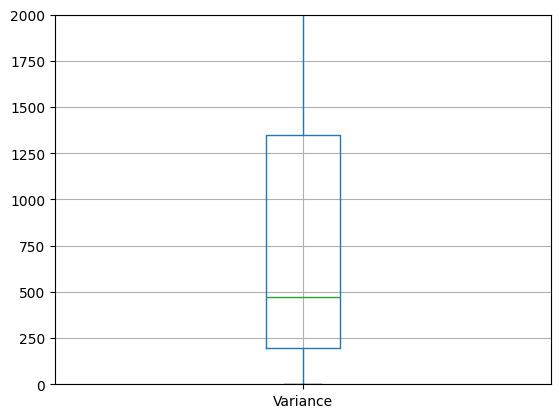

In [15]:
from matplotlib.ticker import ScalarFormatter

#Plot variance distribution

boxplot = df_var.boxplot(column='Variance')

#https://www.reddit.com/r/learnpython/comments/el4vbx/how_to_remove_scientific_notation_from_a/
#Remove scientific notation from y-axis
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

# Set y-axis limits
plt.ylim(0, 2000) 

# Show the plot
plt.show();

## Benchmark

In [53]:
#Importing packages
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sys

In [54]:
#REGRESSION #########################################
#CHANGE LINE BELOW  TO FIT GENE FAMILIES OR KMERS

#For different scoring of cross_validate, check: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter "Regression"
#For the output of cross_validate: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

#Benchmark different thresholds of filtering low-variance features

#Cross-validation packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import statistics
from sklearn.ensemble import RandomForestRegressor

f1_df = pd.DataFrame()

#Loop for different thresholds for filtering low-variance
for i in np.arange(0, 0.11, 0.01):  
#for i in np.arange(0, 1100, 100):
        
    with zstandard.open('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_' + abiotic_factor + '_' + 
                        feature + '_' + str(i) + '.pickle.zst', 'rb') as f: 
        tmp = pickle.load(f)
    
    print('Calculating metrics for threshold', i, 'of filtering low-variance features...')

    list_means = []

    #Separating features from group/target variable
    X = tmp.drop(group, axis=1)
    y = tmp[group]
    
    #Do 10 iterations for every different threshold
    for it in range(1, 11, 1):
#    for it in range(1, 3, 1):        

        #Cross-validation
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=it)
        #Instantiate Random Forest model
        clf = RandomForestRegressor()

        scoring = 'neg_mean_absolute_error'
        output = cross_validate(clf, X, y, cv=5, scoring=scoring, return_train_score=False, return_estimator =True)
        #print(output)
        #{'fit_time': array([57.96, 62.67, 56.21, 67.85, 60.65]), 'score_time': array([0.05, 0.05, 0.05, 0.05, 0.05]), 
        #'estimator': [RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor()], 
        #'test_score': array([-13.17, -12.15, -17.07, -19.26, -32.13])}

        #Get mean MAE for this iteration
        mean = statistics.mean(output['test_score'])
        #Add mean MAE to vector containing results of all iterations
        list_means.append(mean)

        print(' Iteration', it, 'has as mean absolute error =', round(mean, 3), 'All errors:', output['test_score'])
    
    print(' Mean absolute error of cross-validation for all iterations:', round(statistics.mean(list_means), 3))

    #Add new values
    f1_df[i] = list_means

Calculating metrics for threshold 0.0 of filtering low-variance features...
 Iteration 1 has as mean absolute error = -18.895 All errors: [-13.35 -12.25 -17.41 -19.30 -32.16]
 Iteration 2 has as mean absolute error = -18.685 All errors: [-13.22 -12.10 -17.17 -19.09 -31.85]
 Iteration 3 has as mean absolute error = -18.675 All errors: [-13.17 -12.18 -17.19 -19.32 -31.52]
 Iteration 4 has as mean absolute error = -18.79 All errors: [-13.26 -12.23 -17.06 -19.28 -32.12]
 Iteration 5 has as mean absolute error = -18.695 All errors: [-13.31 -11.98 -17.23 -19.26 -31.68]
 Iteration 6 has as mean absolute error = -18.718 All errors: [-13.37 -12.14 -17.26 -19.23 -31.58]
 Iteration 7 has as mean absolute error = -18.795 All errors: [-13.25 -12.14 -17.34 -19.17 -32.07]
 Iteration 8 has as mean absolute error = -18.723 All errors: [-13.41 -12.19 -17.19 -19.29 -31.54]
 Iteration 9 has as mean absolute error = -18.707 All errors: [-13.36 -12.02 -17.15 -19.30 -31.71]
 Iteration 10 has as mean absolute

KeyboardInterrupt: 

In [33]:
#CLASSIFICATION #########################################
#CHANGE LINE BELOW  TO FIT GENE FAMILIES OR KMERS

#Benchmark different thresholds of filtering low-variance features

#Cross-validation packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import statistics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

f1_df = pd.DataFrame()

#Loop for different thresholds for filtering low-variance
for i in np.arange(0, 0.11, 0.01):  
#for i in np.arange(0, 1100, 100):
        
    with zstandard.open('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_' + abiotic_factor + '_' + 
                        feature + '_' + str(i) + '.pickle.zst', 'rb') as f: 
        tmp = pickle.load(f)
    
    print('Calculating metrics for threshold', i, 'of filtering low-variance features...')

    list_means = []

    #Separating features from group/target variable
    X_full = tmp.drop(group, axis=1)
    y_full = tmp[group]
    
    #UNDERSAMPLING - important for classification problems and unbalanced groups
    #Definindo o RandomUnderSampler
    #I used a seed for the random state, which means that the undersampling will always choose the same samples,
    # which in my case is fine, since I am comparing different thresholds
    rus = RandomUnderSampler(random_state=5)
    
    # Aplicando para X e y
    X, y = rus.fit_resample(X_full, y_full)
    
    #Do 10 iterations for every different threshold
    for it in range(1, 11, 1):
#    for it in range(1, 3, 1):        

        #Cross-validation with seed that changes with every iteration. The same split is desired per thresholds, since I want to
        # compare them. However within iterations, I want different splits
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=it)
        #I ran salt, gene-families without seed, and the results were extremely similar
    
        #Instantiate Random Forest model
        clf = RandomForestClassifier()

        scoring = ['f1']
        output = cross_validate(clf, X, y, cv=5, scoring = scoring, return_train_score=False, return_estimator =True)
        #print(output)
        #{'fit_time': array([0.68, 0.73, 0.72, 0.68, 0.61]), 'score_time': array([0.12, 0.11, 0.11, 0.19, 0.11]), 
        #'estimator': [RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier()], 
        #'test_f1': array([0.91, 0.90, 0.88, 0.75, 0.68])}
        
        #Get mean F1 for this iteration
        mean = statistics.mean(output['test_f1'])
        #Add mean F1 to vector containing results of all iterations
        list_means.append(mean)

        print(' Iteration', it, 'has as mean F1 value =', round(mean, 3), 'All values:', output['test_f1'])
    
    print(' Mean F1 score of cross-validation for all iterations:', round(statistics.mean(list_means), 3))

    #Add new values
    f1_df[i] = list_means

Calculating metrics for threshold 0.0 of filtering low-variance features...
 Iteration 1 has as mean F1 value = 0.953 All values: [0.98 1.00 0.98 0.96 0.85]
 Iteration 2 has as mean F1 value = 0.951 All values: [0.98 0.98 0.98 0.96 0.85]
 Iteration 3 has as mean F1 value = 0.953 All values: [0.98 0.99 0.98 0.96 0.85]
 Iteration 4 has as mean F1 value = 0.95 All values: [0.98 1.00 0.97 0.96 0.84]
 Iteration 5 has as mean F1 value = 0.953 All values: [0.98 0.99 0.98 0.96 0.85]
 Iteration 6 has as mean F1 value = 0.95 All values: [0.98 1.00 0.98 0.96 0.84]
 Iteration 7 has as mean F1 value = 0.953 All values: [0.98 1.00 0.98 0.96 0.85]
 Iteration 8 has as mean F1 value = 0.951 All values: [0.98 0.99 0.98 0.96 0.85]
 Iteration 9 has as mean F1 value = 0.952 All values: [0.98 1.00 0.98 0.96 0.84]
 Iteration 10 has as mean F1 value = 0.953 All values: [0.98 1.00 0.98 0.96 0.84]
 Mean F1 score of cross-validation for all iterations: 0.952
Calculating metrics for threshold 0.01 of filtering lo

In [55]:
f1_df

#Save benchmark results to a CSV file
f1_df.to_csv('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_f1_benchmark_' + abiotic_factor + '_' + feature + '.csv', index=True)

,0.00,0.01,0.02,0.03
0,-18.89,-18.92,-19.27,-19.43
1,-18.68,-19.07,-19.20,-19.52
2,-18.67,-18.98,-19.13,-19.64
3,-18.79,-19.03,-19.40,-19.48
4,-18.70,-18.89,-19.19,-19.60
5,-18.72,-18.99,-19.28,-19.62
6,-18.80,-18.96,-19.23,-19.53
7,-18.72,-18.99,-19.26,-19.53
8,-18.71,-19.08,-19.19,-19.53
9,-18.87,-18.92,-19.29,-19.36


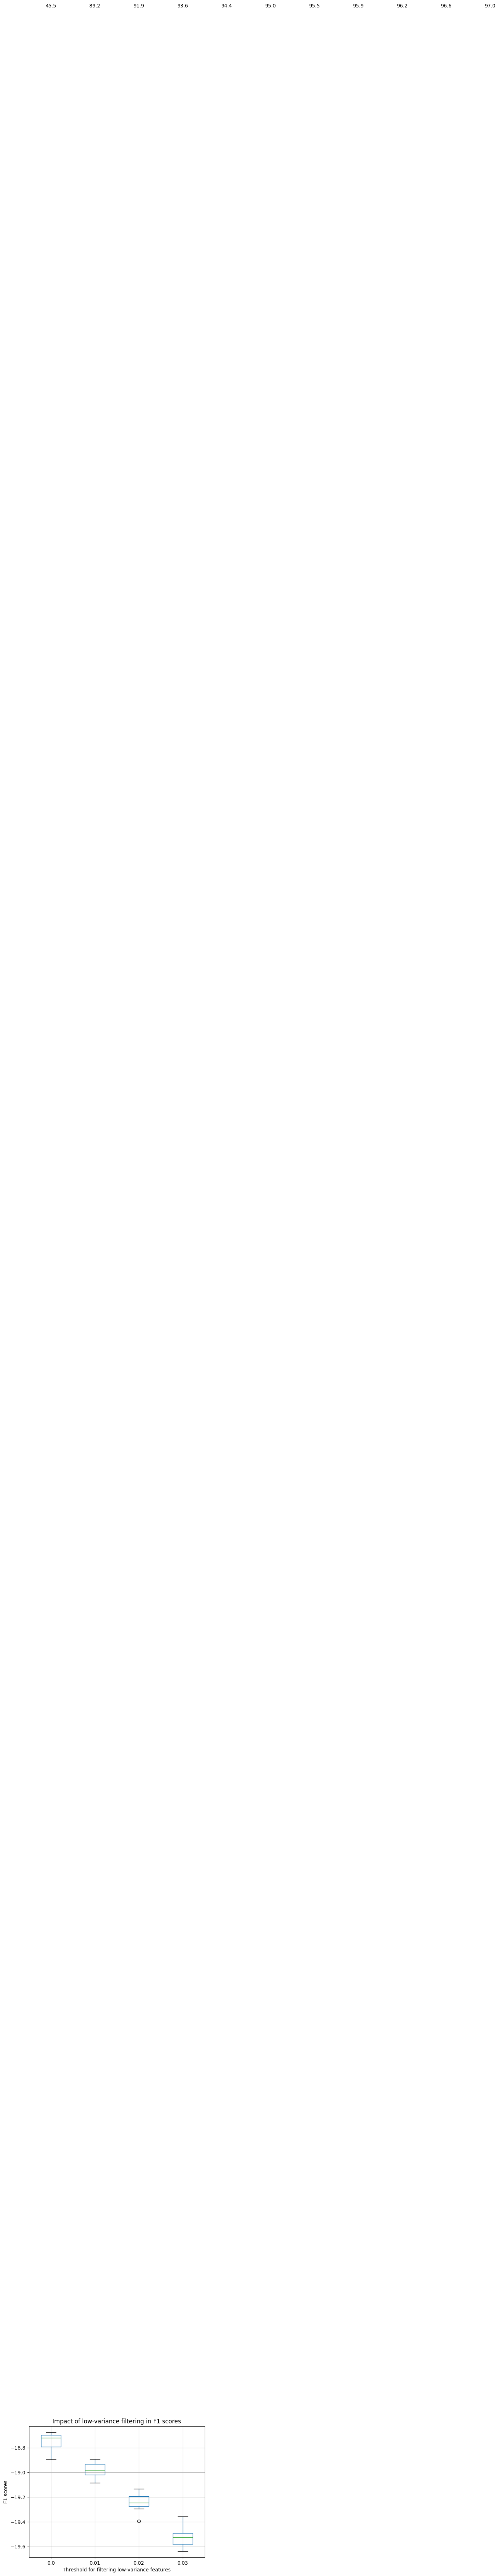

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

#Plot results 

#ADAPT THE LABELS FOR REGRESSION/CLASSIFICATION
#Plot the metrics for the cross-validation

boxplot = f1_df.boxplot();

#values is a list of percentages of low-variance features to be filtered out
labels = values
n_cols = len(labels)
#Height on y-axis where the lables/values should be displayed
draw_at = 0.9579
for x, y, l in zip(range(1,n_cols+1), np.repeat(draw_at, n_cols),
labels):
    boxplot.text(x, y, l, horizontalalignment='center')

#Add axis labels and title
plt.xlabel('Threshold for filtering low-variance features');
plt.ylabel('F1 scores');
#plt.ylabel('Mean Absolute Error (MAE)');
plt.title('Impact of low-variance filtering in F1 scores');
#plt.title('Impact of low-variance filtering in MAEs');

plt.savefig('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/benchmark_' + abiotic_factor + '_' + feature + '.png', dpi=300)

#Show plot
plt.show();